## 信用卡詐欺偵測

異常值偵測是要判斷一個新觀察值是否屬於已知樣本的分布，除了用來找出離群值/新奇值外，也常用在入侵偵測、判斷信用卡交易是否異常等實務應用，尤其是當異常狀況的成本過高或樣本數太少時，異常值偵測技巧更能派上用場。

本綜合範例要讀取信用卡詐欺資料集 creditcard.csv，這是 2013 年歐洲持卡人在兩天內消費數據的一部分，目標要識別詐欺的信用卡交易。

## 欄位名稱
| 欄位名稱 | 說明 |
| -------- | ---- |
| Time | 交易時間。從資料集第一筆交易開始所經過的秒數 |
| V1-V28 | 由 PCA 轉換後的特徵，難以直接觀察出資料的原始意義 |
| Amount | 交易金額 |
| Class | 1:詐欺, 0:非詐欺 |

## 分析程序
1. 計算資料集內詐欺交易的比例，以作為模型的參數值
2. 針對資料集內 29 個特徵欄位（V1, V2, ... V28, Amount），分別利用孤立森林（Isolation Forest）和局部異常因子（Local Outlier Factor），對整個資料集識別詐欺的信用卡交易。

In [1]:
# 忽略警告訊息
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

# 載入信用卡欺詐資料
df = pd.read_csv('creditcard.csv')

# 詐欺交易與正常交易的 dataframe
Fraud = df[df['Class']==1]
Valid = df[df['Class']==0]

# 顯示詐欺交易的前三筆資料
Fraud.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
623,7610,0.73,2.30,-5.33,4.01,-1.73,-1.73,-3.97,1.06,-0.49,...,0.59,0.11,0.60,-0.36,-1.84,0.35,0.59,0.10,1.0,1
664,8808,-4.62,1.70,-3.11,4.33,-1.87,-0.99,-4.58,0.47,0.47,...,0.48,0.15,0.12,-0.22,-0.14,-0.42,-1.00,0.89,1.1,1
924,13323,-5.45,8.29,-12.75,8.59,-3.11,-3.18,-9.25,4.25,-6.33,...,1.85,-0.27,-0.31,-1.20,1.35,0.61,1.57,0.81,1.0,1


In [3]:
# 計算 "Class" 欄位為 1 的比例
outlier_fraction = len(Fraud)/float(df.shape[0])

print('Outlier ratio:', outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

Outlier ratio: 0.0017204452090867595
Fraud Cases : 49
Valid Cases : 28432


In [4]:
# 取出特徵欄位 V1,V2,...,V28,Amount、類別欄位 class
columns = [c for c in df.columns if c not in ['Time', 'Class']]
X_train = df[columns]
y_train = df['Class'] 

In [5]:
# 建立孤立森林、局部異常因子演算法
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# 建立孤立森林演算法物件
obj_if = IsolationForest(
    n_estimators=100, 
    max_samples=len(X_train), 
    contamination=outlier_fraction # 類別 1 的比例
)

# 建立局部異常因子演算法物件
obj_lof = LocalOutlierFactor(
    n_neighbors=20, 
    algorithm='auto',
    leaf_size=30, 
    p=2, # 歐幾里得距離 (L2)
    contamination=outlier_fraction
)

In [6]:
# 分別計算分類錯誤樣本數
list_name = ['孤立森林', '局部異常因子']
list_obj = [obj_if, obj_lof]

print('=== 分類錯誤的樣本數 ===')
for name, obj in zip(list_name, list_obj):
    # 預測訓練資料
    y_pred = obj.fit_predict(X_train)
    
    # 修改預測值： 0->正常交易、1->詐欺交易
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_train).sum()
    
    print(f'{name}：{n_errors}')

    # 找出分類錯誤的樣本
    error_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_train)) if pred != actual]
    print(f'分類錯誤的樣本索引： {error_indices}')
    
    # 顯示錯誤樣本的特徵和預測結果
    error_samples = X_train.iloc[error_indices]
    error_samples['Actual'] = y_train.iloc[error_indices]
    error_samples['Predicted'] = y_pred[error_indices]
    print(f'{name} 分類錯誤樣本資料：\n', error_samples)

=== 分類錯誤的樣本數 ===
孤立森林：74
分類錯誤的樣本索引： [623, 664, 754, 755, 1052, 1079, 1341, 1351, 1381, 1706, 2020, 2061, 2346, 2361, 2422, 2491, 2554, 3129, 3246, 4368, 4402, 4762, 5052, 5736, 5758, 5848, 5849, 6616, 6831, 7510, 8522, 8972, 9180, 9645, 11887, 11990, 12241, 12469, 12476, 12972, 14137, 14686, 14960, 15092, 15386, 15494, 15701, 16737, 17316, 17586, 18288, 18922, 19148, 19227, 21125, 22228, 22675, 22704, 23073, 23431, 23544, 23546, 24334, 24532, 24994, 25431, 26161, 26197, 26314, 27062, 27227, 27416, 27665, 27909]
孤立森林 分類錯誤樣本資料：
          V1    V2    V3    V4    V5    V6     V7     V8    V9    V10  ...  \
623    0.73  2.30 -5.33  4.01 -1.73 -1.73  -3.97   1.06 -0.49  -4.62  ...   
664   -4.62  1.70 -3.11  4.33 -1.87 -0.99  -4.58   0.47  0.47  -5.58  ...   
754   -9.79  8.26 -2.52 -0.90 -2.43  4.53  -8.78 -22.16  3.13   2.34  ...   
755   -6.06  5.24 -1.81  0.67 -3.23  5.41 -10.47 -22.29 -1.21  -5.78  ...   
1052  -2.61  4.49 -8.46  5.69 -4.13 -3.08  -7.71   2.24 -3.39 -11.15  ...   
...  

## 孤立森林 和 局部異常因子 的特徵視覺化

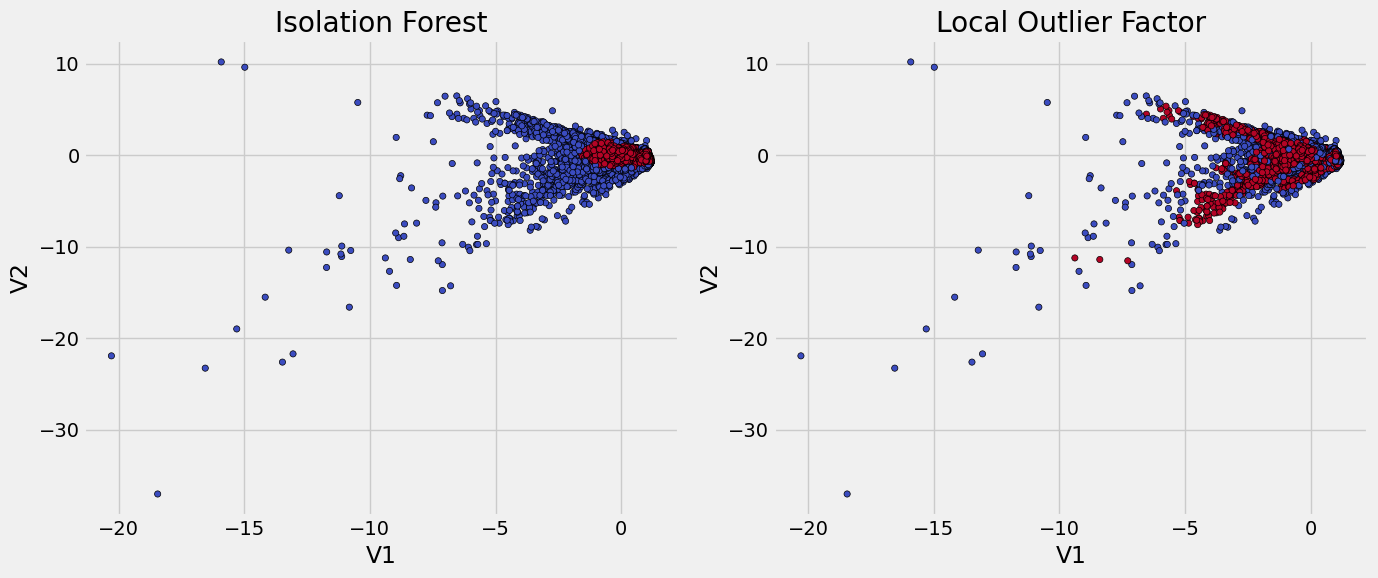

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 選取兩個主要的數值特徵進行分析
features = ['V1', 'V2']
X = df[features]  # 假設 V1 和 V2 是資料中的兩個特徵

# 標準化特徵
X = StandardScaler().fit_transform(X)

# 建立孤立森林演算法物件
iso_forest = IsolationForest(contamination=0.1)
iso_preds = iso_forest.fit_predict(X)

# 建立局部異常因子演算法物件
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_preds = lof.fit_predict(X)

# 將預測結果加入資料
df['IsolationForest'] = iso_preds
df['LocalOutlierFactor'] = lof_preds

# 設定視覺化
plt.figure(figsize=(14, 6))

# 孤立森林視覺化
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=iso_preds, cmap='coolwarm', edgecolor='k', s=20)
plt.title("Isolation Forest")
plt.xlabel(features[0])
plt.ylabel(features[1])

# 局部異常因子視覺化
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=lof_preds, cmap='coolwarm', edgecolor='k', s=20)
plt.title("Local Outlier Factor")
plt.xlabel(features[0])
plt.ylabel(features[1])

plt.tight_layout()
plt.show()